# All imports necessary

In [1]:
import os

In [2]:
import sys

In [3]:
import lightgbm as lgb

In [4]:
import xgboost as xgb

In [5]:
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import multiprocessing

In [10]:
sys.path.append('..')

In [11]:
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import auc

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
from sklearn.preprocessing import OrdinalEncoder

In [19]:
from sklearn.compose import ColumnTransformer

In [20]:
from sklearn.metrics import roc_curve

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
from source.code.transformers.metafeaturesextractor import MetaFeaturesExtractor

In [24]:
from source.code.models.svdbasedrecommender import SVDBasedRecommender

In [25]:
from source.code.models.songfrequencybasedrecommender import SongFrequencyBasedRecommender

In [26]:
from source.code.models.factorizationmachinebasedrecommender import FactorizationMachineBasedRecommender

In [27]:
from source.code.models.lightgbmbasedrecommender import LightGBMBasedRecommender

In [28]:
from source.code.models.xgboostbasedrecommender import XGBoostBasedRecommender

In [29]:
from source.code.models.ensemblebasedrecommender import EnsembleBasedRecommender

In [30]:
from tqdm.autonotebook import tqdm

# Auxiliary methods

In [31]:
def plot_roc_auc(fpr, tpr, classifier):
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.10f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example ({})'.format(classifier))
    plt.legend(loc="lower right")
    plt.show()

# Read the data

In [32]:
data_directory = '../data/datasets/'

In [33]:
unknown_category_label = 'unknown'

In [34]:
unknown_language_label = -1

## Train

In [35]:
train = pd.read_csv(os.path.join(data_directory, 'train.csv'), engine='python')

In [36]:
train.head(4).T

,0,1,2,3
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
source_system_tab,explore,my library,my library,my library
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more
source_type,online-playlist,local-playlist,local-playlist,local-playlist
target,1,1,1,1


In [37]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  7377418 non-null object
song_id               7377418 non-null object
source_system_tab     7352569 non-null object
source_screen_name    6962614 non-null object
source_type           7355879 non-null object
target                7377418 non-null int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


## Test

In [38]:
test = pd.read_csv(os.path.join(data_directory, 'test.csv'), engine='python')

In [39]:
test.head(4).T

,0,1,2,3
id,0,1,2,3
msno,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=
song_id,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=
source_system_tab,my library,my library,discover,radio
source_screen_name,Local playlist more,Local playlist more,NaN,Radio
source_type,local-library,local-library,song-based-playlist,radio


In [40]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
id                    2556790 non-null int64
msno                  2556790 non-null object
song_id               2556790 non-null object
source_system_tab     2548348 non-null object
source_screen_name    2393907 non-null object
source_type           2549493 non-null object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


## Songs

In [41]:
songs = pd.read_csv(os.path.join(data_directory, 'songs.csv'))

In [42]:
songs.head(4).T

,0,1,2,3
song_id,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=
song_length,247640,197328,231781,273554
genre_ids,465,444,465,465
artist_name,張信哲 (Jeff Chang),BLACKPINK,SUPER JUNIOR,S.H.E
composer,董貞,TEDDY| FUTURE BOUNCE| Bekuh BOOM,NaN,湯小康
lyricist,何啟弘,TEDDY,NaN,徐世珍
language,3,31,31,3


In [43]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        2296320 non-null object
song_length    2296320 non-null int64
genre_ids      2202204 non-null object
artist_name    2296320 non-null object
composer       1224966 non-null object
lyricist       351052 non-null object
language       2296319 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


## Members

In [44]:
members = pd.read_csv(os.path.join(data_directory, 'members.csv'))

In [45]:
members.head(4).T

,0,1,2,3
msno,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=
city,1,1,1,1
bd,0,0,0,0
gender,NaN,NaN,NaN,NaN
registered_via,7,7,4,9
registration_init_time,20110820,20150628,20160411,20150906
expiration_date,20170920,20170622,20170712,20150907


In [46]:
members.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null object
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null object
registered_via            34403 non-null int64
registration_init_time    34403 non-null int64
expiration_date           34403 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


## Sample submission

In [47]:
sample_submission = pd.read_csv(os.path.join(data_directory, 'sample_submission.csv'))

In [48]:
sample_submission.head(4).T

,0,1,2,3
id,0.0,1.0,2.0,3.0
target,0.5,0.5,0.5,0.5


In [49]:
sample_submission.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        2556790 non-null int64
target    2556790 non-null float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB


# Solutions

## Train / Test split preparation

In [50]:
X, y = train[train.columns[:-1]], train[train.columns[-1]]

In [51]:
X_for_submission = test[test.columns]

In [52]:
X.head(4).T

,0,1,2,3
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
source_system_tab,explore,my library,my library,my library
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more
source_type,online-playlist,local-playlist,local-playlist,local-playlist


In [53]:
y.head(4).T

0    1
1    1
2    1
3    1
Name: target, dtype: int64

In [54]:
X_for_submission.head(4).T

,0,1,2,3
id,0,1,2,3
msno,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=
song_id,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=
source_system_tab,my library,my library,discover,radio
source_screen_name,Local playlist more,Local playlist more,NaN,Radio
source_type,local-library,local-library,song-based-playlist,radio


In [55]:
X[['msno', 'song_id']].values.shape

(7377418, 2)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [57]:
print(X_train.shape, y_train.shape)

(5164192, 5) (5164192,)


In [58]:
print(type(X_train), type(y_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [59]:
print(X_test.shape, y_test.shape)

(2213226, 5) (2213226,)


In [60]:
print(type(X_test), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


## Preprocessing steps description

In [61]:
categorical_features = [
    'source_system_tab',
    'source_screen_name',
    'city',
    'gender'
]

In [62]:
categorical_features_lang = [
    'language'
]

In [63]:
numerical_features = [
    'bd',
    'song_length'
]

In [64]:
numerical_features_days_reg = [
    'days_registered'
]

In [65]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [66]:
num_features_pipeline_days_reg = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [67]:
cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_category_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [68]:
cat_features_pipeline_lang = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_language_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, numerical_features),
        ('num_days_reg', num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', cat_features_pipeline, categorical_features),
        ('cat_lang', cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [70]:
unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('preprocessing', preprocessor)
    ]
)

## Naive frequency approach

In [230]:
naive_frequency_recommender = SongFrequencyBasedRecommender()

In [231]:
naive_frequency_recommender.fit(X_train, y_train)

SongFrequencyBasedRecommender()

In [232]:
y_pred = naive_frequency_recommender.predict_proba(X_test)

In [233]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

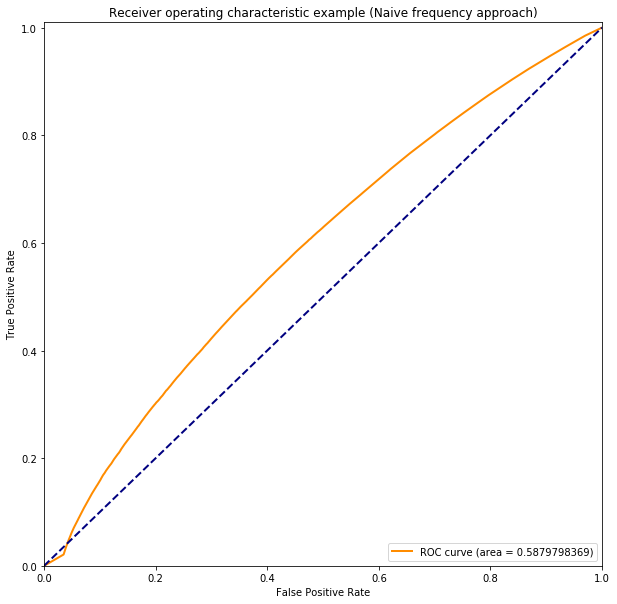

In [234]:
plot_roc_auc(fpr, tpr, 'Naive frequency approach')

## SVD

In [235]:
svd_recommender = SVDBasedRecommender()

In [236]:
svd_recommender.fit(X_train, y_train)

SVDBasedRecommender()

In [237]:
y_pred = svd_recommender.predict_proba(X_test)

In [238]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

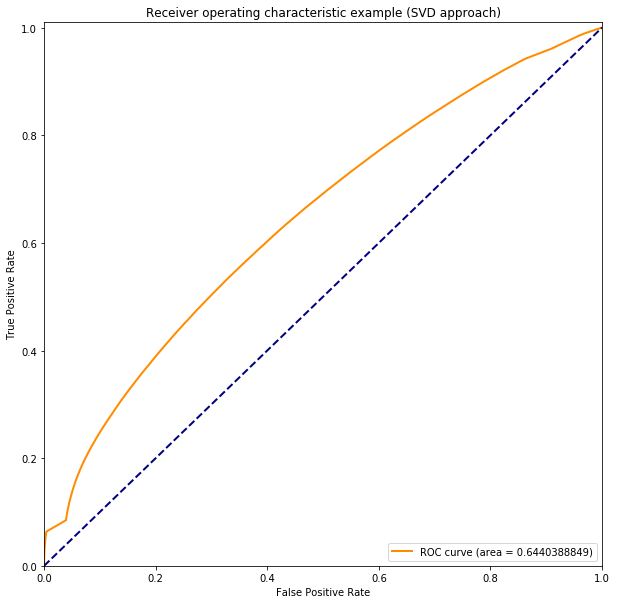

In [239]:
plot_roc_auc(fpr, tpr, 'SVD approach')

## FM

In [240]:
fm_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', FactorizationMachineBasedRecommender(show_progress=True))
    ]
)

In [241]:
fm_classifier_pipeline.fit(X_train, y_train.values)

100%|██████████| 100/100 [38:00<00:00, 22.91s/epoch]


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD..., ['language'])]))])), ('classification', FactorizationMachineBasedRecommender(show_progress=True))])

In [242]:
y_pred = fm_classifier_pipeline.predict_proba(X_test)

In [243]:
y_pred.shape

(2213226,)

In [244]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

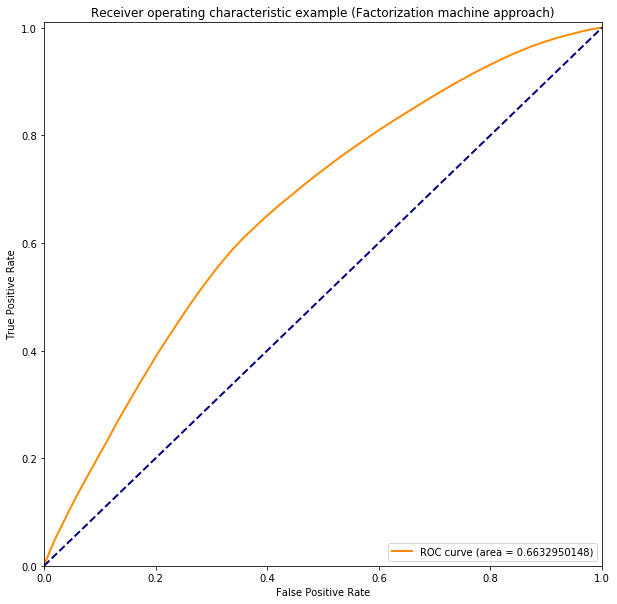

In [245]:
plot_roc_auc(fpr, tpr, 'Factorization machine approach')

## LightGBM

In [246]:
lgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', LightGBMBasedRecommender())
    ]
)

In [247]:
lgb_classifier_pipeline.fit(X_train, y_train.values)

Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD..., sparse=False))]), ['language'])]))])), ('classification', LightGBMBasedRecommender(val_size=0.3))])

In [248]:
y_pred = lgb_classifier_pipeline.predict_proba(X_test)

In [249]:
y_pred.shape

(2213226,)

In [250]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

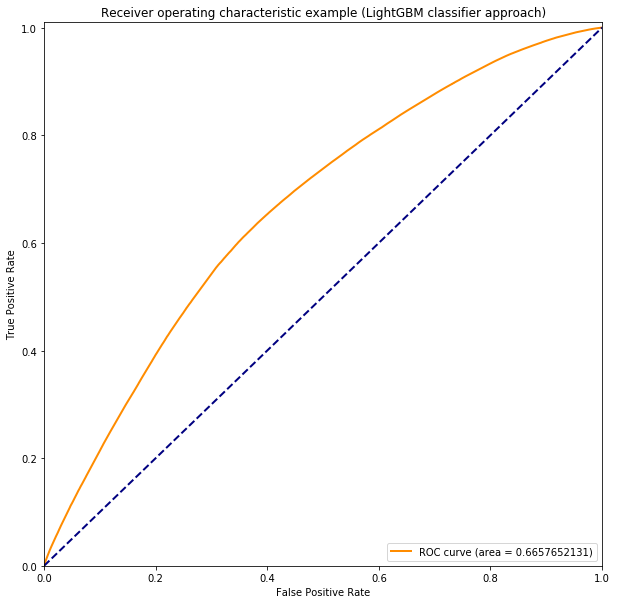

In [251]:
plot_roc_auc(fpr, tpr, 'LightGBM classifier approach')

## XGBoost

In [252]:
xgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', XGBoostBasedRecommender())
    ]
)

In [253]:
xgb_classifier_pipeline.fit(X_train, y_train.values)

[15:13:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD...e, sparse=False))]), ['language'])]))])), ('classification', XGBoostBasedRecommender(val_size=0.3))])

In [254]:
y_pred = xgb_classifier_pipeline.predict_proba(X_test)

In [255]:
y_pred.shape

(2213226,)

In [256]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

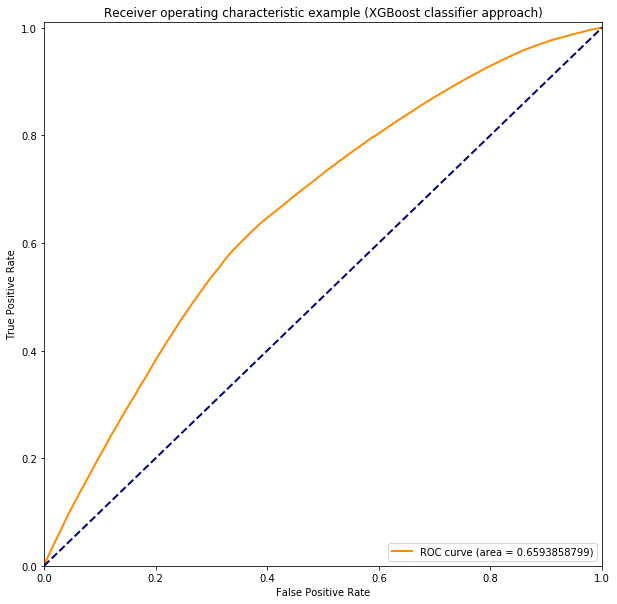

In [257]:
plot_roc_auc(fpr, tpr, 'XGBoost classifier approach')

## StarSpace

In [71]:
star_space_num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='ordinal'))
])

In [72]:
star_space_num_features_pipeline_days_reg = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='ordinal'))
])

In [73]:
star_space_cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_category_label)),
    ('encode', OrdinalEncoder())
])

In [74]:
star_space_cat_features_pipeline_lang = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_language_label)),
    ('encode', OrdinalEncoder())
])

In [75]:
star_space_preprocessor = ColumnTransformer(
    transformers=[
        ('num', star_space_num_features_pipeline, numerical_features),
        ('num_days_reg', star_space_num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', star_space_cat_features_pipeline, categorical_features),
        ('cat_lang', star_space_cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [76]:
star_space_unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('preprocessing', star_space_preprocessor)
    ]
)

In [76]:
X_star_space = star_space_unified_pipeline.fit_transform(X, y)

In [71]:
X.shape

(7377418, 5)

In [72]:
numerical_features + numerical_features_days_reg + categorical_features + categorical_features_lang

['bd',
 'song_length',
 'days_registered',
 'source_system_tab',
 'source_screen_name',
 'city',
 'gender',
 'language']

In [ ]:
X_star_space.shape

In [80]:
X_star_space = pd.DataFrame(X_star_space, columns=numerical_features + numerical_features_days_reg + categorical_features + categorical_features_lang)

In [81]:
X_star_space.head()

,bd,song_length,days_registered,source_system_tab,source_screen_name,city,gender,language
0,1.0,0.0,2.0,1.0,7.0,0.0,2.0,8.0
1,2.0,3.0,3.0,3.0,8.0,11.0,0.0,8.0
2,2.0,1.0,3.0,3.0,8.0,11.0,0.0,8.0
3,2.0,2.0,3.0,3.0,8.0,11.0,0.0,0.0
4,1.0,0.0,2.0,1.0,7.0,0.0,2.0,8.0


In [82]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null float64
song_length           7377418 non-null float64
days_registered       7377418 non-null float64
source_system_tab     7377418 non-null float64
source_screen_name    7377418 non-null float64
city                  7377418 non-null float64
gender                7377418 non-null float64
language              7377418 non-null float64
dtypes: float64(8)
memory usage: 450.3 MB


In [83]:
X_star_space.bd = X_star_space.bd.astype(np.int32)
X_star_space.song_length = X_star_space.song_length.astype(np.int32)
X_star_space.days_registered = X_star_space.days_registered.astype(np.int32)
X_star_space.source_system_tab = X_star_space.source_system_tab.astype(np.int32)
X_star_space.source_screen_name = X_star_space.source_screen_name.astype(np.int32)
X_star_space.city = X_star_space.city.astype(np.int32)
X_star_space.gender = X_star_space.gender.astype(np.int32)
X_star_space.language = X_star_space.language.astype(np.int32)

In [84]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null int32
song_length           7377418 non-null int32
days_registered       7377418 non-null int32
source_system_tab     7377418 non-null int32
source_screen_name    7377418 non-null int32
city                  7377418 non-null int32
gender                7377418 non-null int32
language              7377418 non-null int32
dtypes: int32(8)
memory usage: 225.1 MB


In [85]:
curr = 0

In [86]:
bd_map = dict(zip(X_star_space.bd.unique(), range(curr, curr + len(X_star_space.bd.unique()))))
curr += len(X_star_space.bd.unique())

In [87]:
song_length_map = dict(zip(X_star_space.song_length.unique(), range(curr, curr + len(X_star_space.song_length.unique()))))
curr += len(X_star_space.song_length.unique())

In [88]:
days_registered_map = dict(zip(X_star_space.days_registered.unique(), range(curr, curr + len(X_star_space.days_registered.unique()))))
curr += len(X_star_space.days_registered.unique())

In [89]:
source_system_tab_map = dict(zip(X_star_space.source_system_tab.unique(), range(curr, curr + len(X_star_space.source_system_tab.unique()))))
curr += len(X_star_space.source_system_tab.unique())

In [90]:
source_screen_name_map = dict(zip(X_star_space.source_screen_name.unique(), range(curr, curr + len(X_star_space.source_screen_name.unique()))))
curr += len(X_star_space.source_screen_name.unique())

In [91]:
city_map = dict(zip(X_star_space.city.unique(), range(curr, curr + len(X_star_space.city.unique()))))
curr += len(X_star_space.city.unique())

In [92]:
gender_map = dict(zip(X_star_space.gender.unique(), range(curr, curr + len(X_star_space.gender.unique()))))
curr += len(X_star_space.gender.unique())

In [93]:
language_map = dict(zip(X_star_space.language.unique(), range(curr, curr + len(X_star_space.language.unique()))))

In [94]:
bd_map

{0: 3, 1: 0, 2: 1, 3: 2}

In [95]:
song_length_map

{0: 4, 1: 6, 2: 7, 3: 5}

In [96]:
days_registered_map

{0: 11, 1: 10, 2: 8, 3: 9}

In [97]:
source_system_tab_map

{0: 15, 1: 12, 2: 18, 3: 13, 4: 19, 5: 17, 6: 14, 7: 20, 8: 16}

In [98]:
source_screen_name_map

{0: 26,
 1: 31,
 2: 40,
 3: 29,
 4: 27,
 5: 35,
 6: 38,
 7: 21,
 8: 22,
 9: 24,
 10: 36,
 11: 25,
 12: 33,
 13: 41,
 14: 30,
 15: 32,
 16: 37,
 17: 34,
 18: 39,
 19: 28,
 20: 23}

In [99]:
city_map

{0: 42,
 1: 58,
 2: 50,
 3: 45,
 4: 51,
 5: 59,
 6: 55,
 7: 46,
 8: 54,
 9: 56,
 10: 49,
 11: 43,
 12: 52,
 13: 44,
 14: 61,
 15: 53,
 16: 57,
 17: 62,
 18: 60,
 19: 47,
 20: 48}

In [100]:
gender_map

{0: 64, 1: 65, 2: 63}

In [101]:
language_map

{0: 67, 1: 69, 2: 71, 3: 70, 4: 72, 5: 68, 6: 75, 7: 74, 8: 66, 9: 73}

In [102]:
X_star_space.bd = X_star_space.bd.map(bd_map)
X_star_space.song_length = X_star_space.song_length.map(song_length_map)
X_star_space.days_registered = X_star_space.days_registered.map(days_registered_map)
X_star_space.source_system_tab = X_star_space.source_system_tab.map(source_system_tab_map)
X_star_space.source_screen_name = X_star_space.source_screen_name.map(source_screen_name_map)
X_star_space.city = X_star_space.city.map(city_map)
X_star_space.gender = X_star_space.gender.map(gender_map)
X_star_space.language = X_star_space.language.map(language_map)

In [103]:
X_star_space.head()

,bd,song_length,days_registered,source_system_tab,source_screen_name,city,gender,language
0,0,4,8,12,21,42,63,66
1,1,5,9,13,22,43,64,66
2,1,6,9,13,22,43,64,66
3,1,7,9,13,22,43,64,67
4,0,4,8,12,21,42,63,66


In [104]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null int64
song_length           7377418 non-null int64
days_registered       7377418 non-null int64
source_system_tab     7377418 non-null int64
source_screen_name    7377418 non-null int64
city                  7377418 non-null int64
gender                7377418 non-null int64
language              7377418 non-null int64
dtypes: int64(8)
memory usage: 450.3 MB


In [105]:
X_star_space.to_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'X_star_space.csv'), index=False, header=False, sep=' ')

In [106]:
# Code for StarSpace installation:
# TBD on new machine

In [107]:
! ../../Starspace/starspace

Usage: need to specify whether it is train or test.

"starspace train ..."  or "starspace test ..."

The following arguments are mandatory for train: 
  -trainFile       training file path
  -model           output model file path

The following arguments are mandatory for test: 
  -testFile        test file path
  -model           model file path

The following arguments for the dictionary are optional:
  -minCount        minimal number of word occurences [1]
  -minCountLabel   minimal number of label occurences [1]
  -ngrams          max length of word ngram [1]
  -bucket          number of buckets [2000000]
  -label           labels prefix [__label__]

The following arguments for training are optional:
  -initModel       if not empty, it loads a previously trained model in -initModel and carry on training.
  -trainMode       takes value in [0, 1, 2, 3, 4, 5], see Training Mode Section. [0]
  -fileFormat      currently support 'fastText' and 'labelDoc', see File Format Section. [fast

In [ ]:
! ../../Starspace/starspace train \
-trainFile /mnt/PROMO_INVESTIGATION_DATA/X_star_space.csv \
-model /mnt/PROMO_INVESTIGATION_DATA/star_space_model \
-trainMode 5

In [108]:
X_star_space_emb = pd.read_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'star_space_model.tsv'), delimiter='\t', header=None)

In [109]:
X_star_space_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [110]:
# SSF stands for StarSpace Feature
X_star_space_emb.columns = ['SSF_{}'.format(i) for i in range(101)]

In [111]:
X_star_space_emb.head()

,SSF_0,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [112]:
X_star_space_emb.rename({"SSF_0": "WORD"}, axis=1, inplace=True)

In [113]:
X_star_space_emb.head()

,WORD,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [114]:
X_star_space_emb.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 101 columns):
WORD       76 non-null int64
SSF_1      76 non-null float64
SSF_2      76 non-null float64
SSF_3      76 non-null float64
SSF_4      76 non-null float64
SSF_5      76 non-null float64
SSF_6      76 non-null float64
SSF_7      76 non-null float64
SSF_8      76 non-null float64
SSF_9      76 non-null float64
SSF_10     76 non-null float64
SSF_11     76 non-null float64
SSF_12     76 non-null float64
SSF_13     76 non-null float64
SSF_14     76 non-null float64
SSF_15     76 non-null float64
SSF_16     76 non-null float64
SSF_17     76 non-null float64
SSF_18     76 non-null float64
SSF_19     76 non-null float64
SSF_20     76 non-null float64
SSF_21     76 non-null float64
SSF_22     76 non-null float64
SSF_23     76 non-null float64
SSF_24     76 non-null float64
SSF_25     76 non-null float64
SSF_26     76 non-null float64
SSF_27     76 non-null float64
SSF_28     76 non-null float64

In [115]:
X_star_space_emb.set_index('WORD', inplace=True)

In [116]:
X_star_space_emb.head()

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
WORD,,,,,,,,,,,,,,,,,,,,,
69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,7.571830e-07,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,7.885580e-09,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,-7.174000e-07,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,9.077260e-09,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,6.226500e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [117]:
X_star_space.loc[0]

bd                     0
song_length            4
days_registered        8
source_system_tab     12
source_screen_name    21
city                  42
gender                63
language              66
Name: 0, dtype: int64

In [118]:
X_star_space_emb.loc[X_star_space.loc[4]]

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
WORD,,,,,,,,,,,,,,,,,,,,,
0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,-7.174000e-07,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
4,-4.812270e-07,4.084920e-08,7.005940e-07,-2.684940e-07,3.438240e-07,-1.657010e-07,-5.519390e-07,-2.725110e-07,3.980780e-07,-3.044820e-07,...,2.116550e-08,-1.596280e-07,1.825300e-07,3.970640e-07,-8.019650e-08,-1.178420e-07,-2.235920e-07,9.676410e-07,4.185190e-07,-3.626890e-07
8,-1.223630e-07,1.684040e-08,2.405200e-07,-5.494900e-08,1.428260e-07,-1.189870e-07,-2.417540e-07,-1.509490e-07,1.564490e-07,-2.173460e-07,...,9.480370e-09,-5.819560e-08,7.882750e-08,1.159660e-07,-5.523370e-08,-7.612320e-09,-9.669030e-08,3.618580e-07,1.578320e-07,-1.082020e-07
12,9.707400e-08,-4.188540e-08,-1.761910e-07,-7.931190e-09,3.016770e-08,-1.147810e-07,2.025150e-07,1.331860e-07,-2.254790e-07,1.852380e-07,...,6.855590e-08,-1.000420e-07,-4.053070e-08,-6.251500e-07,1.246260e-07,1.815200e-07,2.673580e-07,-9.106940e-07,-3.379350e-07,4.787010e-07
21,3.753390e-08,-1.005010e-07,-1.459210e-07,-8.492260e-08,5.942110e-08,-1.332420e-07,1.286710e-07,8.340860e-08,-1.226270e-07,1.771380e-07,...,1.752610e-08,-1.605590e-07,-1.902580e-08,-5.510360e-07,9.083820e-08,1.373610e-07,2.597430e-07,-8.323160e-07,-2.714670e-07,3.853400e-07
42,1.125690e-08,3.017250e-10,-1.603960e-08,7.729870e-09,-6.484850e-09,3.591270e-09,1.743080e-08,1.138790e-08,-1.368310e-08,1.077520e-08,...,2.458290e-10,1.022630e-08,-6.023820e-09,-1.263620e-08,3.580050e-09,2.304400e-09,7.835510e-09,-3.044890e-08,-1.203900e-08,1.421310e-08
63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,6.226500e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07
66,1.166150e-06,-3.416190e-08,-1.739460e-06,7.362910e-07,-8.409110e-07,4.135960e-07,1.335690e-06,6.633340e-07,-1.022450e-06,7.517510e-07,...,-8.719680e-08,4.354200e-07,-4.123370e-07,-9.780300e-07,2.754930e-07,2.769500e-07,5.166960e-07,-2.398200e-06,-1.036690e-06,9.549190e-07


In [119]:
def do_something(number):
    return X_star_space_emb.loc[X_star_space.loc[number]].mean()

In [120]:
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    X_star_space_emb_extr = pd.concat(p.map(do_something, range(X_star_space.shape[0])), axis=1)

In [121]:
X_star_space_emb_extr = X_star_space_emb_extr.transpose()

In [122]:
X_star_space_emb_extr.head()

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,3.302860e-08,-6.318259e-09,-5.222595e-08,4.629010e-09,1.692244e-09,-3.961772e-08,7.124297e-08,5.152981e-08,-5.591939e-08,6.354052e-08,...,4.117087e-09,-1.500037e-09,-1.663948e-08,-1.760413e-07,2.874888e-08,3.627076e-08,8.198753e-08,-2.830237e-07,-8.559087e-08,1.387086e-07
1,4.472596e-08,1.315368e-08,-6.526620e-08,5.715419e-08,-3.141219e-08,5.795625e-10,-8.644062e-09,-3.173606e-08,-3.633320e-08,-6.628140e-08,...,-1.891064e-08,-6.267874e-09,2.167328e-08,-1.521584e-08,2.104276e-08,3.417748e-08,-1.924162e-08,-8.167750e-09,-1.199346e-08,4.339433e-08
2,4.987021e-08,1.754737e-08,-6.932445e-08,5.696994e-08,-3.506631e-08,6.386875e-10,-6.596187e-09,-3.129043e-08,-3.532832e-08,-6.433152e-08,...,-1.769668e-08,-5.038499e-09,1.950203e-08,-1.391571e-08,2.010989e-08,3.345196e-08,-1.745099e-08,-1.023225e-08,-1.313734e-08,4.101957e-08
3,4.122196e-08,2.811531e-08,-5.114020e-08,5.570894e-08,-2.859831e-08,-3.192687e-09,-9.241812e-09,-2.929793e-08,-3.965782e-08,-6.633927e-08,...,-1.694748e-08,-1.210962e-08,2.166553e-08,-2.263196e-08,1.672452e-08,2.426171e-08,-2.292224e-08,2.967250e-09,1.519037e-09,2.980083e-08
4,3.302860e-08,-6.318259e-09,-5.222595e-08,4.629010e-09,1.692244e-09,-3.961772e-08,7.124297e-08,5.152981e-08,-5.591939e-08,6.354052e-08,...,4.117087e-09,-1.500037e-09,-1.663948e-08,-1.760413e-07,2.874888e-08,3.627076e-08,8.198753e-08,-2.830237e-07,-8.559087e-08,1.387086e-07


In [123]:
X_star_space_emb_extr.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 100 columns):
SSF_1      7377418 non-null float64
SSF_2      7377418 non-null float64
SSF_3      7377418 non-null float64
SSF_4      7377418 non-null float64
SSF_5      7377418 non-null float64
SSF_6      7377418 non-null float64
SSF_7      7377418 non-null float64
SSF_8      7377418 non-null float64
SSF_9      7377418 non-null float64
SSF_10     7377418 non-null float64
SSF_11     7377418 non-null float64
SSF_12     7377418 non-null float64
SSF_13     7377418 non-null float64
SSF_14     7377418 non-null float64
SSF_15     7377418 non-null float64
SSF_16     7377418 non-null float64
SSF_17     7377418 non-null float64
SSF_18     7377418 non-null float64
SSF_19     7377418 non-null float64
SSF_20     7377418 non-null float64
SSF_21     7377418 non-null float64
SSF_22     7377418 non-null float64
SSF_23     7377418 non-null float64
SSF_24     7377418 non-null float64
SSF_25     7377418 non

In [124]:
starspace_features = X_star_space_emb_extr.columns

In [125]:
starspace_features = starspace_features.values.tolist()

In [126]:
X_star_space_emb_extr = pd.concat([X[['msno', 'song_id']], X_star_space_emb_extr], axis=1)

In [127]:
X_star_space_emb_extr.to_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'X_star_space_emb_extr.csv'))

In [70]:
X_star_space_emb_extr = pd.read_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'X_star_space_emb_extr.csv'))

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

In [72]:
starspace_features = ['SSF_{}'.format(i) for i in range(1, 51)]

In [73]:
class StarSpaceFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, star_space_meta):
        self.star_space_meta = star_space_meta
        self.X_with_meta = None

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        self.X_with_meta = X.copy()
        self.X_with_meta = pd.merge(self.X_with_meta, self.star_space_meta, on=['msno', 'song_id'], how='left')
        return self.X_with_meta

In [74]:
star_space_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, numerical_features + starspace_features),
        ('num_days_reg', num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', cat_features_pipeline, categorical_features),
        ('cat_lang', cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [75]:
star_space_unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('add_star_space_features', StarSpaceFeaturesExtractor(star_space_meta=X_star_space_emb_extr)),
        ('preprocessing', star_space_preprocessor)
    ]
)

In [83]:
star_space_lgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', star_space_unified_pipeline),
        ('classification', LightGBMBasedRecommender())
    ]
)

In [258]:
star_space_lgb_classifier_pipeline.fit(X_train, y_train.values)

Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD..., sparse=False))]), ['language'])]))])), ('classification', LightGBMBasedRecommender(val_size=0.3))])

In [260]:
y_pred = star_space_lgb_classifier_pipeline.predict_proba(X_test)

In [261]:
y_pred.shape

(2213226,)

In [262]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

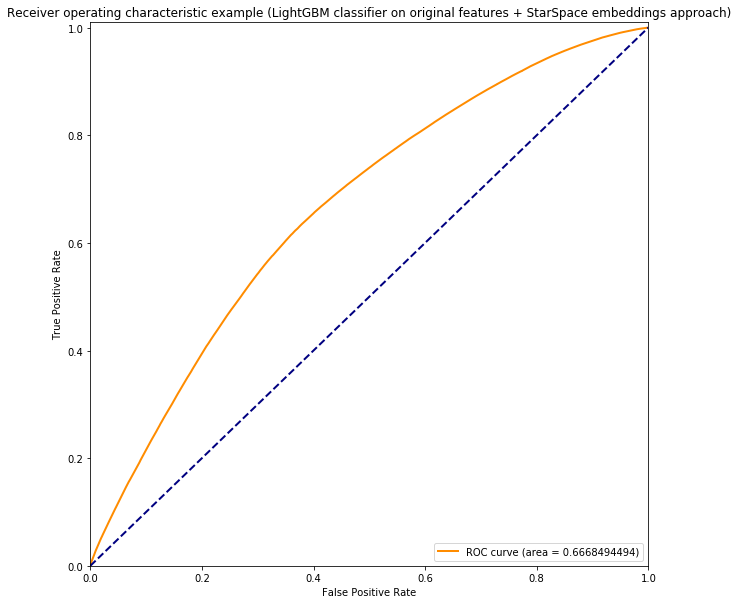

In [263]:
plot_roc_auc(fpr, tpr, 'LightGBM classifier on original features + StarSpace embeddings approach')

## Ensemble

In [264]:
ens_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', EnsembleBasedRecommender(
            base_estimators=[
                FactorizationMachineBasedRecommender(),
                LightGBMBasedRecommender(),
                XGBoostBasedRecommender()
            ]
        ))
    ]
)

In [265]:
ens_classifier_pipeline.fit(X_train, y_train.values)

100%|██████████| 3/3 [24:12<00:00, 697.08s/it] 


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD...ecommender(val_size=0.3), XGBoostBasedRecommender(val_size=0.3)],
             ens_train_size=0.4))])

In [266]:
y_pred = ens_classifier_pipeline.predict_proba(X_test)

100%|██████████| 3/3 [00:07<00:00,  3.29s/it]


In [267]:
y_pred.shape

(2213226,)

In [268]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

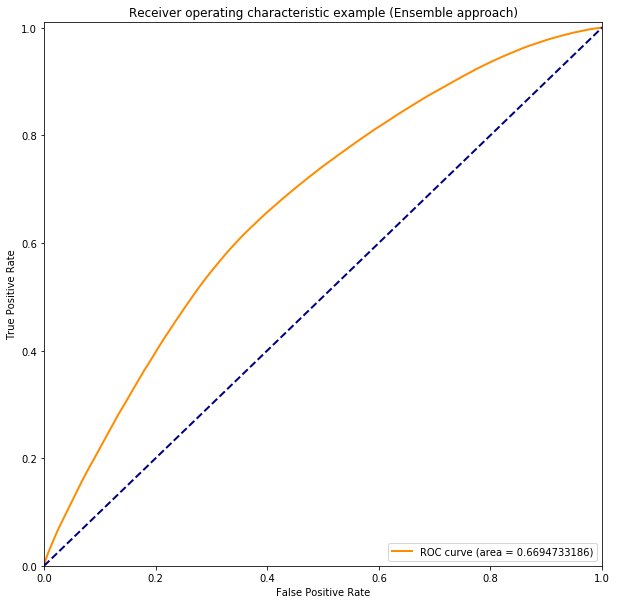

In [270]:
plot_roc_auc(fpr, tpr, 'Ensemble approach')

## Ensemble + StarSpace features

In [76]:
star_space_ens_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', star_space_unified_pipeline),
        ('classification', EnsembleBasedRecommender(
            base_estimators=[
                FactorizationMachineBasedRecommender(),
                LightGBMBasedRecommender(),
                XGBoostBasedRecommender()
            ]
        ))
    ]
)

In [77]:
star_space_ens_classifier_pipeline.fit(X_train, y_train.values)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [55:21<00:00, 1584.69s/it]  


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD...ecommender(val_size=0.3), XGBoostBasedRecommender(val_size=0.3)],
             ens_train_size=0.4))])

In [78]:
y_pred = star_space_ens_classifier_pipeline.predict_proba(X_test)

100%|██████████| 3/3 [00:18<00:00,  7.90s/it]


In [79]:
y_pred.shape

(2213226,)

In [80]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

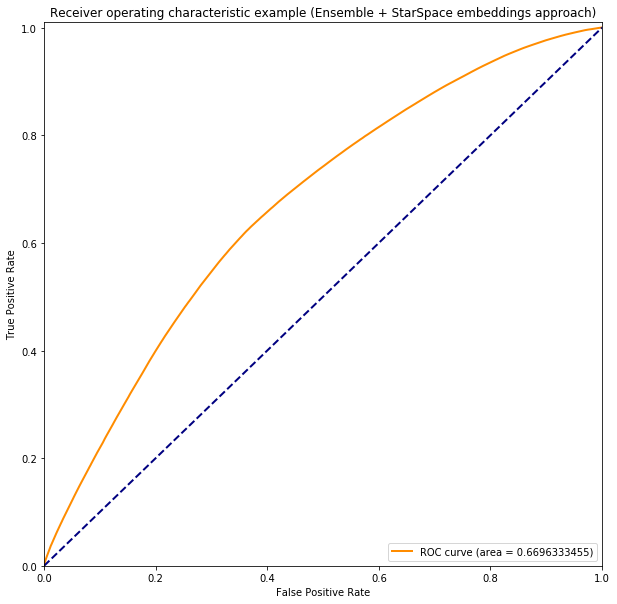

In [81]:
plot_roc_auc(fpr, tpr, 'Ensemble + StarSpace embeddings approach')

# Submission

In [ ]:
star_space_ens_classifier_pipeline.fit(X, y.values)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
y_pred_subm = ens_classifier_pipeline.predict_proba(X_for_submission)

In [ ]:
y_pred_subm.shape

In [ ]:
X_for_submission['target'] = y_pred_subm

In [ ]:
X_for_submission[['id', 'target']].to_csv(os.path.join(data_directory, 'ensemble_submission_full_train_part.csv'), index=False)

# Conclusion

So as it could be expected the ensemble approach with additional StarSpace features performed the best of all.
Still, uploaded onto Kaggle solution shows the quality (ROC-AUC) that is significantly less than the quality calculated locally.
That can be caused by the time-component being lost.
Also it might be the case that the ground-truth target variable distribution is different from what was given in the train sample.
Since the train is just some sample within a specific time duration (that was said in the data description) the distribution of the target in train might not reflect the real distribution accurately.
Moreover the real distribution will be changing with time since it is still time-dependent (old songs become irrelevent )